# MNIST Convolutional Network

* 建立卷積神經網路 (convolutional neural network)
* 用 MNIST 來訓練 CNN
* 評估模型

In [1]:
!pip install tensorflow
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import math
%matplotlib inline
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
sess = tf.InteractiveSession()
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


## 建立多層的卷積神經網路

前一個模型我們得到 92% 的準確率是非常不及格的．在這裡我們將建立一個更為適當且複雜的模型．也就是一個小型的 **卷積神經網路** (convolutional neural network)．在 MNIST 的準確度會提升到 99.2% 或許不是最好但也相當不錯的成績．

## 權重初始化

在建立模型之前我們需要建立一系列的權重 (weights) 還有偏移量 (biases)．為了避免 權重 (weight) 過於對稱還有 0 梯度 (gradient) 我們必須加入一小部分的為正的噪音 (noise)．因為我們使用的是 [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))，因此特別適合在偏移量 (bias) 初始化為為正的數值來避免 **'神經元死去 (dead neurons)'**．這裡建立了兩個函數來避免每次使用他的時候都重新建立程式碼．

In [2]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)
def bias_variable(shape):
    initial = tf.constant(0.1, shape = shape)
    return tf.Variable(initial)

## 卷積還有池化 (Convolution and Pooling)

(在這裡實在不知道怎麼翻譯，因此用阿陸仔的名詞來稱呼)

Tensorflow 同樣給我們很大的彈性來做卷積還有池化這兩個動作．如何處理邊界? 我們的 stride 大小要設多少? 在這個範例中，我們會一直使用 vanilla 的版本．我們的卷積過程中的參數 `stride` 會是 1 而 `padded` 則是 0．也因此輸入還有輸出都會是同樣的大小 (size)．而我們的 polling 則是用 2X2 的傳統 polling 來做．為了讓我們的程式更加簡潔，我們同樣把這樣的操作抽象成函數．

In [3]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding = 'SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')

## 第一個卷積層

我們現在可以來實現第一個卷積層．他會先有一個卷積接著一個 max polling 來完成．這個卷積會從 5x5 的 patch 算出 32 個特徵．他的權重 tensor 的形狀是 [5, 5, 1, 32]．頭兩個維度是 patch 的大小，下一個則是輸入的 channels，最後一個則是輸出的 channels．同樣的在輸出也會有偏移量向量 (bias vector)．

In [4]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

現在要來把輸入 `x` 來導入我們剛剛建立的第一個卷積層，那必須先把 `x` 轉換成一個 4d 的 tensor，其中第二個和第三個維度對應到了圖片的寬度和高度，而最後一個則對應到了顏色的 channel 數 (這裡因為是灰階的所以 channel 為 1)

In [5]:
x_image = tf.reshape(x, [-1, 28, 28, 1])

我們接下來把 `x_image` 還有權重 tensor 輸入剛剛定義的卷積函數，再來加上偏移值 (bias) 後輸入 **ReLU** 函數，最後經過 max pooling． `max_pool_2x2` 函數會把圖片的大小縮成 14x14．

In [6]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

## 第二個卷積層

為了建立比較深度的神經網路，我們把許多層疊在一起．第二層會從 5x5 的 patch 中取出 64 個特徵．

In [7]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

## 密集的全連接層

現在讓我們想像圖片的大小已經被縮成了 7x7 的大小，我們加入一個 1024 的全連接層來把前面的全部輸出輸入全連接層．其中包含了先把 pooling 的輸出展開後乘上一個權重矩陣再加上一個偏移量向量，最後輸入 ReLU．

In [215]:
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7 * 7 * 64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

## Dropout

為了減少 overfitting，在輸出層之前我們會加入 dropout 層．首先我們建立了一個站位子 (`placeholder`) 來代表神經元在 dropout 過程中不變的機率．這可以讓我們決定要在訓練的時候打開 dropout，而在測試的時候關閉 dropout． Tensorflow 的 `tf.nn.dropout` 除了會遮蔽神經元的輸出以外也會自動對輸入值做 scaling，所以我們在使用的時候可以不用考慮 scale．

註: 對於這種比較小的卷積網路，有沒有 dropout 對於成果不會有太大影響．dropout 是一個非常好的方法來減低 overfitting，但僅限於比較大的神經網路．

In [216]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

## 輸出層

最後我們加上像之前 softmax regression 一樣的層．

In [217]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

## 訓練以及評估模型

那我們的模型表現的如何呢? 這裡我們會用之前 `Softmax` 範例的大部分程式碼來訓練以及評估這個模型．

不過有幾點不同的是:

* 我們會把 gradient descent 最佳化演算法換成更為精密的 ADAM 最佳化演算法．
* 我們會在 `feed_dict` 參數之中加入 `keep_prob` 這個參數來控制 dropout 的機率．
* 我們會在每一百個回合的訓練中印出紀錄

現在你可以來執行這段程式，但它需要 20,000 回合的訓練，可能會需要比較久的時間 (大概半小時)，當然如果你的處理器比較好的話也可能會比較快．

In [218]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()
sess.run(tf.global_variables_initializer())
for i in range(20000):
  batch = mnist.train.next_batch(50)
  if i%100 == 0:
    train_accuracy = accuracy.eval(feed_dict={
        x:batch[0], y_: batch[1], keep_prob: 1.0})
    print("step %d, training accuracy %g"%(i, train_accuracy))
  train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})

print("test accuracy %g"%accuracy.eval(feed_dict={
    x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

save_path = saver.save(sess, "/root/model.ckpt")

step 0, training accuracy 0.08
step 100, training accuracy 0.8
step 200, training accuracy 0.9
step 300, training accuracy 0.94
step 400, training accuracy 0.96
step 500, training accuracy 0.9
step 600, training accuracy 0.92
step 700, training accuracy 0.94
step 800, training accuracy 0.9
step 900, training accuracy 0.96
step 1000, training accuracy 0.98
step 1100, training accuracy 0.96
step 1200, training accuracy 0.98
step 1300, training accuracy 0.98
step 1400, training accuracy 0.92
step 1500, training accuracy 0.96
step 1600, training accuracy 0.96
step 1700, training accuracy 0.96
step 1800, training accuracy 0.98
step 1900, training accuracy 0.98
step 2000, training accuracy 0.98
step 2100, training accuracy 0.96
step 2200, training accuracy 0.94
step 2300, training accuracy 0.98
step 2400, training accuracy 1
step 2500, training accuracy 0.98
step 2600, training accuracy 0.96
step 2700, training accuracy 1
step 2800, training accuracy 0.98
step 2900, training accuracy 0.98
st

最後的測試準確度大約為 99.2%

我們學到了用 Tensorflow 是可以很快速而且簡單的建置，訓練，以及評估一個較為精密的深度學習模型．

## CNN 流程

好的，我們現在已經成功了用 CNN 達到了非常不錯的準確率 (99.2%)，接下來就是來看一下到底它用了什麼樣的方法造成這麼厲害的結果，以及實現 CNN 的 Tensorflow 程式碼裡面的一些參數代表什麼意義？

CNN 的用意，大概有以下三點:

1. **圖片中的特徵往往比整張圖片還要小**

   ex. 一張人臉照片中，幾個重要特徵會是眼睛，鼻子，耳朵．．．等．

2. **而圖片中的特徵常常是會重複出現的**

   ex. 一張人臉照片中，兩個眼睛特徵是非常相似的．

3. **要盡量的減少神經網路中的參數**

   ex. 如果輸入的圖片很大而且每個像素都連結到隱含層，這樣權重的數目會太多，導致計算困難．

那根據以上幾點我們回來看一下 CNN 的結構

![](http://imgur.com/bYFnDws.jpg)

圖片輸入會經過兩個卷積層 (convolutional layer) 然後把它扳平 (Flatten) 之後進入全連結層 (Fully Connected Layer) 最後就是進入 Softmax 分類成 10 個數字．

這些流程中的關鍵就是卷積層 (convolutional layer) ，卷積層的出現讓 CNN 可以達到上面的三個目標，接下來就讓我們一起看下去．

## 卷積層 Convolutional Layer

卷積層中有三個部分，我們會邊用邊用程式邊解說: 

* Convolution
* ReLU
* Max Pooling

![](http://imgur.com/2KE40Oo.jpg)



### 卷積層 Convolutional Layer

以下是建立 `convolution` 的五行程式碼: 

```python
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding = 'SAME')
x_image = tf.reshape(x, [-1, 28, 28, 1])
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
result = conv2d(x_image, W_conv1) + b_conv1
```
我們先從 `x_image = tf.reshape(x, [-1, 28, 28, 1])` 開始看，它的用意是把圖片像素輸入變成一個 1x28x28x1 的四維矩陣．

* 第一個參數為 -1 的意思是不管輸入有幾個，Tensorflow 會自動調整的意思，假設輸入 50 個圖片第一個維度就是 50．
* 第二個第三個就是指數字圖片為 28 像素 x 28 像素 的意思
* 最後一個則是指色階，這裡又稱 **channel**，這裡因為我們的輸入都是黑白灰階，因此值為 1．如果是彩色圖有 RGB 三原色，這裡的數值就是 3．

`W_conv1 = weight_variable([5, 5, 1, 32])` 則是建立起過濾器 (filter)．過濾器我覺得也可以稱作特徵篩選器，可以想像說是負責來辨認圖片中的某些特徵，像是直線或是橫線或是轉彎處．

* 一二三維的數字 `[5, 5, 1]` 代表著這個過濾器是一個 5x5x1 的矩陣，這跟上面的圖片一樣 5x5 代表著 5 像素 x 5 像素，而 1 則代表著灰階．
* 最後一個數字 32 代表著我們建立了 32 個過濾器來篩選特徵．

`b_conv1 = bias_variable([32])` 建立一個偏移值 (bias) 避免負數．

好的那現在讓我們先看一下經過訓練後的前 16 個過濾器到底長得怎麼樣，因此我們必須先建立兩個工具函數，分別可以: 
1. 印出過濾器的權重值
2. 印出輸入圖片經過過濾器後的輸出

In [111]:
def plot_conv_weights(weights, num_filters, input_channel = 0):
    
    # 這裡的 w 我們預計是一個 4 維的 tensor，ex. [5, 5, 1, 32]
    # 因此要先用 session 取出數值變成 ndarray
    w = sess.run(weights)
    
    num_grids = int(math.ceil(math.sqrt(num_filters)))
    w_min = np.min(w)
    w_max = np.max(w)
    
    fig, axes = plt.subplots(num_grids, num_grids)
    
    for i, ax in enumerate(axes.flat):
        if i < num_grids * num_grids:
            img = w[:, :, input_channel, i]
            
            ax.imshow(img, vmin = w_min, vmax=w_max, interpolation = 'nearest', cmap = 'seismic')
        
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

而它的結果為下圖，其中紅色表示大於零的值，藍色表示小於零的值．

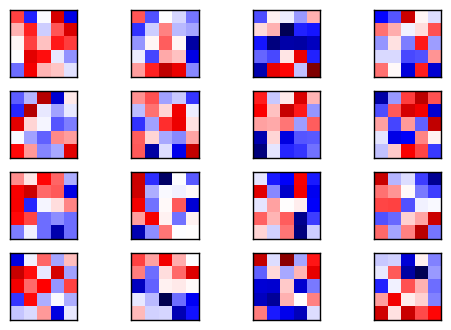

In [114]:
plot_conv_weights(W_conv1, 16)

接下來我們想看到每個過濾器對應的輸出是如何，所以我們要先定義一個印出 layer 輸出的函數

In [116]:
def plot_conv_layer(layer, image, num_filters):
    # layer 輸入範例是 [batch_num, width, height, channels] ex. [1, 28, 28, 32]
    # 這裡設定的 image 是單一個手寫字影像輸入
    # 接下來把它餵入 tensorflow 的 session 跑出我們想要的輸出結果
    output = sess.run(layer, feed_dict = {x: [image]})
    
    num_grids = int(math.ceil(math.sqrt(num_filters)))
    
    fig, axes = plt.subplots(num_grids, num_grids)
    
    for i, ax in enumerate(axes.flat):
        if i < num_grids * num_grids:
            img = output[0, :, :, i]
            ax.imshow(img, interpolation='nearest', cmap='gray')
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

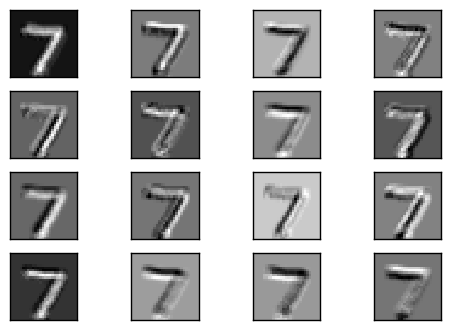

In [120]:
output_conv1 = conv2d(x_image, W_conv1) + b_conv1
image1 = mnist.test.images[0]
plot_conv_layer(output_conv1, image1, 16)

呃如果直接從圖片上面來看你看得出有什麼端倪嗎？

我們可以發現幾點

1. 如果過濾器中有藍色**橫線** (ex. 左下角) 那在輸出就會出現數字中有藍色**橫線**的地方
2. 如果過濾器中有藍色**斜線** (ex. 右上角) 那在輸出就會出現數字中有藍色**斜線**的地方

感覺這樣是不是每個過濾器所辨認到的 **特徵**都不一樣呢？接下來讓我們仔細看看 Filter, ReLU, MaxPooling 的細節．

## 過濾器 (Filter)

從上面的結果中我們看到過濾器中似乎會對有同樣特徵的輸入產生反應，例如過濾器如果有紅色橫線的存在，那對應輸出圖片的紅色橫線就會特別明顯．那這段過程中過濾器和輸入圖片是如何的互動關係呢？

答案是 : **Convolution！**

避免掉了數學上的複雜我們直接用下面的 gif 來解釋，假設有一個 4 x 4 x 1 的輸入圖片，過濾器是 3 x 3 x 1，然後給定參數 stride = 1，可以看到過濾器開始從左上角往右以及往下和紅色的區域做點積 (每個對應元素相乘，最後全部相加)，得到的結果就是 2．再來我們會注意到紅色區域往右移了一格，而一格就是 stride 的值所對應的，同樣的當紅色區域到達最右邊後他會從左邊往下一格開始依序做點積，而最後的成果就是輸出矩陣了．

我們可以依此類推，如果 stride = 2 那就是紅色區域一次會移動兩格的意思．

![](http://imgur.com/8XHiO5I.gif)



但這時侯回頭看一下 conv2d 的定義會看到還有一個參數值是 padding．

```python
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding = 'SAME')
```

padding 為 SAME 的意思是就是要讓輸入和輸出的大小是一樣的，因為從上面的例子看到經過 convolution 以後 size 變小了，那如果要一樣的話，我們做的事情就是把輸入一開始補上 0 如下圖，那再去跑一次 convolution 就會得到一樣大小的圖片了．

![](http://imgur.com/qch3liz.jpg)

## ReLU 激活函數

在這裡我們會把上面的輸出都通過一個函數如下，其實就是 `x < 0` 的時候全部為 0，而 `x > 0` 則為 x．要做激活函數的原因是因為要模擬出非線性函數，簡單想像就是加入激活函數可以讓神經網路學到更多奇奇怪怪的東西．

而之前小弟在學校訓練原始 nn 的時候好像是用 `sigmoid` or `tanh`，大概查了一下是因為 ReLU 更簡單 ，在深度的網路裡面計算更快．(結果小於零就認定你辨識不出來，就把你關掉！譬如說一個過濾器是來辨識眼睛，若是發現圖片完全沒有眼睛，則輸出以後就會小於零，那經過 ReLU 以後，後面的神經網路就不會知道有這個特徵了，因為這個特徵被關掉了．)．

![](http://cs231n.github.io/assets/nn1/relu.jpeg)

如下圖，就是經過 ReLU 後的結果，只剩下紅色大於零的輸出．

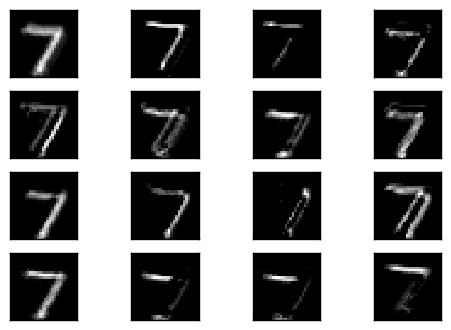

In [122]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1)) + b_conv1
max_pool_2x2(h_conv1)

## 最大池化器 MaxPooling

好的，convolutional layer 的最後一個地方就是 max pooling 了，話說我一直不太喜歡池化器這個翻譯...因為好饒口啊．

記得前面有提到說 CNN 有個目標就是想要把參數降低，而我們學習是為了學習特徵，因此不一定要從高清（？中學習，可以把它變得沒那麼清楚一點．這裡做的事情就是 `downsampling`！那要怎麼樣既 down sampling 又保留特徵呢？以下就是一個示範：

首先我們用一個 2x2 的矩陣來掃過輸入 (stride = 2)，然後在每個紅色區域裡都找那個區域裡最大值當作輸出，就這樣就完成了 down sampling 了！

![](http://imgur.com/MxuEsSo.gif)

以下就是經過 max-pooling 的結果了！

## 第二卷積層輸出

前一篇中我們主要觀察了第一個卷積層的輸出以及內部結構．那我們今天要來觀察的就是第二個卷積層的作用．

還記得前一層中最後的結果是 14 x 14 x 32 的輸出，而這輸出就是要在把它餵入第二個卷積層．第二個卷積層構造跟前一個幾乎是一模一樣

* 5 x 5 的過濾器但是會產生 64 個輸出
* MaxPooling 再一次，因此會做 downsampling 一次，使得輸出為 7 x 7
* 一樣有 ReLU

好的那讓我們看一下各個位置的輸出:

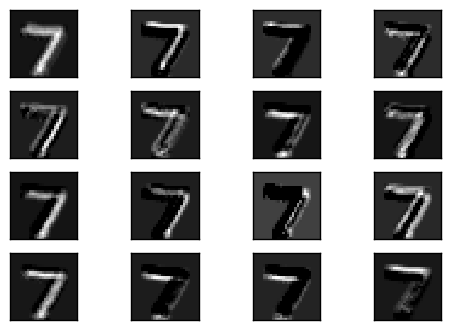

In [124]:
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
plot_conv_layer(h1,mnist.test.images[0], 16)

In [132]:
print "output shape: %s" % (h_pool1.eval(feed_dict= {x: mnist.test.images}).shape,)

output shape: (10000, 14, 14, 32)


我們可以看到經過 MaxPooling 以後 size 變成 14 x 14．
## 第二卷積層輸出

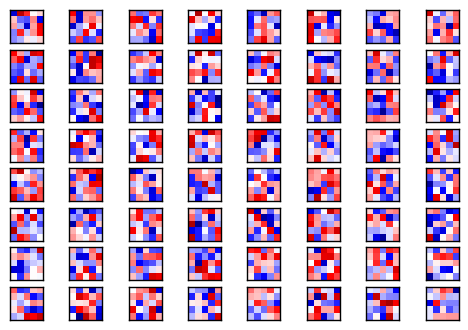

In [142]:
# 印出第二層的 weights
plot_conv_weights(W_conv2, 64)

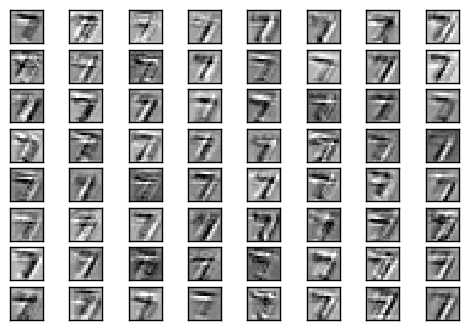

In [143]:
# 印出第二層經過過濾器的結果
plot_conv_layer(conv2d(h_pool1, W_conv2), mnist.test.images[0], 64)

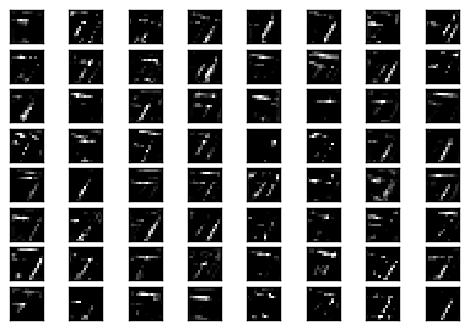

In [144]:
# 印出第二層經過 ReLU 的結果
plot_conv_layer(tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2), mnist.test.images[0], 64)

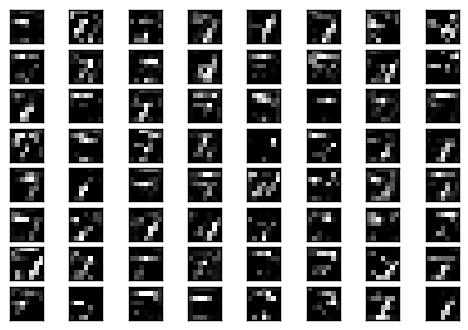

In [145]:
# 印出第二層經過 MaxPooling 的結果
plot_conv_layer(max_pool_2x2(tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)), mnist.test.images[0], 64)

## 好的我實在不知道它學出了什麼特徵了！
## 但可以從白點的位置看到，第二層相比第一層會針對更小的特徵起反應．

## 全連結層 Fully Connected Layer
為什麼最後需要這一個全連結層呢？
可以想像的是，前面的層學出了很多的 **特徵** ，而這些特徵的 **組合** 可以幫助我們分辨現在這個影像輸入是哪一個數字！然後加入全連結層是一個非常簡便的方法來把這些特徵集合組合在一起然後從中做分類．

## Dropout
而在全連結層之後會接一個 dropout 函數，而它是為了來避免 overfitting 的神器，通常在訓練過程會使用（這裡的 p = 0.5）意思就是會這些神經元會隨機的被關掉，要這樣的做的原因是避免神經網路在訓練的時候防止特徵之間有合作的關係．
隨機的關掉一些節點後，原本的神經網路就被逼迫著從剩下不完整的網路來學習，而不是每次都透過特定神經元的特徵來分類．
通俗的講法就是，我們要百般刁難這個網路，讓它在各種很艱困的情形下學習，**不經一番寒徹骨，哪得梅花撲鼻香**（怎麼越來越覺得訓練網路好像在做軍事訓練一樣．．．）



# '深度'學習
看完了以上 CNN 的結構以後，那為什麼這個方法叫做**深度**學習呢？

因為呀就是大家發現如果**越多層**效果會越好!!

試了一下把第二個卷積層拿掉以後，準確率就掉到了 98.88%．
而在知名的圖片比賽 ImageNet，更可以看到這幾年贏的模型，可說是越來越深呢．．．
![](https://pic2.zhimg.com/v2-a2e264580fd9856daccf20eb15c32571_b.jpg)
(原圖連結：https://www.zhihu.com/question/43370067）

## 今日心得
今天從第二層的輸出看到了和第一層不同辨識特徵的差別，然後了解了為什麼後面還要接一個全連接層和 dropout 的原因．
